In [ ]:
!nvidia-smi

Sun Feb  7 14:30:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!apt update
!apt install xvfb
!pip install pyvirtualdisplay

from IPython import display
from pyvirtualdisplay import Display
disp = Display()
disp.start()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (165 kB/s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class Tetris:
    colors: np.ndarray = np.array([
        [0, 0, 0],
        [255, 255, 0],
        [147, 88, 254],
        [54, 175, 144],
        [255, 0, 0],
        [102, 217, 238],
        [254, 151, 32],
        [0, 0, 255]
    ], dtype=np.uint8)

    pieces: np.ndarray = np.array([
        [[0, 0],   [0, 0], [0, 0],  [0, 0]],  # None
        [[0, -1],  [0, 0], [-1, 0], [-1, 1]],  # S
        [[0, -1],  [0, 0], [1, 0],  [1, 1]],  # Z
        [[0, -1],  [0, 0], [0, 1],  [0, 2]],  # I
        [[-1, 0],  [0, 0], [1, 0],  [0, 1]],  # T
        [[1, 0],   [0, 0], [0, 1],  [1, 1]],  # O
        [[-1, -1], [0, 0], [0, -1], [0, 1]],  # J
        [[1, -1],  [0, 0], [0, -1], [0, 1]]],  # L
    )

    def __init__(self, num_rows: int = 20, num_cols: int = 10, block_size: int = 20) -> None:
        self.num_rows: int = num_rows
        self.num_cols: int = num_cols
        self.block_size: int = block_size

        self.board: np.ndarray = np.empty((self.num_rows, self.num_cols), dtype=np.uint8)
        self.score: float = 0.0
        self.cleared_lines: int = 0
        self.shape: int = 0
        self.piece: np.ndarray = np.empty_like(self.pieces[0])
        self.position: dict = {"x": 0, "y": 0}
        self.gameover: bool = False

        self.last_value: float = 0.0

    def reset(self) -> np.ndarray:
        self.board.fill(0)
        self.score = 0.0
        self.cleared_lines = 0
        self.new_piece()
        self.gameover = False
        self.last_value = 0.0
        return (self.board > 0).astype(float)

    def rotate(self, piece: np.ndarray) -> None:
        rotation_270 = np.array([[0, -1], [1, 0]])
        np.dot(piece, rotation_270, out=piece)

    # def get_state_properties(self, board):
    #     lines_cleared, board = self.clear_lines(board)
    #     holes = self.get_holes(board)
    #     bumpiness, height = self.get_bumpiness_and_height(board)

    #     return [lines_cleared, holes, bumpiness, height]

    # def get_holes(self, board):
    #     num_holes = 0
    #     for col in zip(*board):
    #         row = 0
    #         while row < self.height and col[row] == 0:
    #             row += 1
    #         num_holes += len([x for x in col[row + 1:] if x == 0])
    #     return num_holes

    # def get_bumpiness_and_height(self, board):
    #     board = np.array(board)
    #     mask = board != 0
    #     invert_heights = np.where(
    #         mask.any(axis=0), np.argmax(mask, axis=0), self.height)
    #     heights = self.height - invert_heights
    #     total_height = np.sum(heights)
    #     currs = heights[:-1]
    #     nexts = heights[1:]
    #     diffs = np.abs(currs - nexts)
    #     total_bumpiness = np.sum(diffs)
    #     return total_bumpiness, total_height

    def get_num_holes(self) -> int:
        exists_piece = self.board != 0
        top_indicies = np.where(
            np.any(exists_piece, axis=0), np.argmax(exists_piece, axis=0), self.num_rows)
        row_indicies = np.repeat(
            np.arange(self.board.shape[0])[:, np.newaxis],
            self.board.shape[1],
            axis=1)
        below_top = row_indicies > top_indicies

        num_holes = np.sum(np.logical_and(np.logical_not(exists_piece), below_top))
        print(num_holes)
        return num_holes

    def get_max_height(self) -> int:
        exists_piece = self.board != 0
        invert_heights = np.where(
            np.any(exists_piece, axis=0), np.argmax(exists_piece, axis=0), self.num_rows)
        heights = self.num_rows - invert_heights
        max_height = np.max(heights)
        print(max_height)
        return max_height

    def get_total_bumpiness(self) -> int:
        exists_piece = self.board != 0
        invert_heights = np.where(
            np.any(exists_piece, axis=0), np.argmax(exists_piece, axis=0), self.num_rows)
        heights = self.num_rows - invert_heights
        diffs = np.abs(heights[:-1] - heights[1:])
        total_bumpiness = np.sum(diffs)
        print(total_bumpiness)
        return total_bumpiness

    def get_next_states(self) -> dict:
        states = {}
        piece = self.piece.copy()
        position = {"x": 0, "y": 0}
        assert self.shape != 0
        if self.shape == 5:
            num_rotations = 1
        elif self.shape in [1, 2, 3]:
            num_rotations = 2
        else:
            num_rotations = 4

        for num_rotation in range(num_rotations):
            for x in range(-piece[:, 0].min(), self.num_cols - piece[:, 0].max()):
                position["x"] = x
                position["y"] = -piece[:, 1].min()
                if self.check_collision(piece, position):
                    continue

                while not self.check_collision(piece, position):
                    position["y"] += 1
                position["y"] -= 1

                board = self.board.copy()
                self.store(piece, self.shape, position, board)
                states[(x, num_rotation)] = (board > 0).astype(float)
            self.rotate(piece)
        return states

    # def get_current_board_state(self):
    #     board = [x[:] for x in self.board]
    #     for y in range(self.piece.shape[0]):
    #         for x in range(len(self.piece[y])):
    #             board[y + self.position["y"]][x +
    #                                           self.position["x"]] = self.piece[y][x]
    #     return board

    def new_piece(self) -> bool:
        self.shape = np.random.randint(0, 7) + 1
        np.copyto(self.piece, self.pieces[self.shape])
        self.position["x"] = self.num_cols // 2 - 1
        self.position["y"] = -self.piece[:, 1].min()

        self.gameover = self.check_collision(self.piece, self.position)

        return self.gameover

    def check_collision(self, piece: np.ndarray, position: dict) -> bool:
        next_xs = position['x'] + piece[:, 0]
        next_ys = position['y'] + piece[:, 1]
        return np.any(next_xs < 0) or np.any(self.num_cols <= next_xs) or \
            np.any(next_ys < 0) or np.any(self.num_rows <= next_ys) or \
            np.any(self.board[next_ys, next_xs]) != 0

    def store(self, piece: np.ndarray, shape: int, position: dict, board: np.ndarray) -> None:
        xs = position["x"] + piece[:, 0]
        ys = position["y"] + piece[:, 1]
        board[ys, xs] = shape

    def clear_lines(self, board: np.ndarray) -> int:
        num_cleared_lines = 0
        for y in range(self.num_rows):
            if all(board[y] != 0):
                for i in range(y, 0, -1):
                    np.copyto(board[i], board[i - 1])
                num_cleared_lines = num_cleared_lines + 1
        return num_cleared_lines

    def step(self, action: tuple) -> tuple:
        x, num_rotations = action
        for _ in range(num_rotations):
            self.rotate(self.piece)
        self.position["x"] = x
        self.position["y"] = -self.piece[:, 1].min()

        while not self.check_collision(self.piece, self.position):
            self.position["y"] += 1
        self.position["y"] -= 1

        self.store(self.piece, self.shape, self.position, self.board)

        num_cleared_lines = self.clear_lines(self.board)

        reward = num_cleared_lines ** 2 + 1
        # current_value = - 0.5 * self.get_max_height() \
        #     + num_cleared_lines ** 2 \
        #     - 0.25 * self.get_num_holes() \
        #     - 0.25 * self.get_total_bumpiness()
        # reward = current_value - self.last_value
        # self.last_value = current_value

        self.score += reward
        self.cleared_lines += num_cleared_lines
        gameover = self.new_piece()
        if gameover:
            reward -= 2
        return reward, gameover

    def render(self) -> np.ndarray:
        board = self.board.copy()
        if not self.gameover:
            self.store(self.piece, self.shape, self.position, board)
        return self.colors[board]

(0, 0)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 0)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

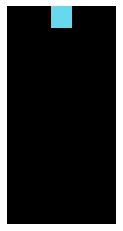

In [ ]:
env = Tetris()
env.reset()

next_steps = env.get_next_states()
for key in next_steps.keys():
    print(key)
    print(next_steps[key])
img = env.render()
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn


class TetrisNet(nn.Module):
    def __init__(self, init_weights=True):
        super(TetrisNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            # nn.BatchNorm2d(256),
            # nn.ReLU(True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU(True),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 1),
        )

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [ ]:
import random
from collections import namedtuple
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

# from .models import TetrisNet


Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    def __init__(self, capacity: int) -> None:
        self.capacity: int = capacity
        self.memory: List[Transition] = []
        self.position: int = 0

    def push(self, *args: Tuple) -> None:
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size: int) -> List[Transition]:
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)


class Brain(object):
    def __init__(
            self,
            lr: float = 1e-4,
            batch_size: int = 512,
            gamma: float = 0.99,
            initial_eps: float = 1.0,
            final_eps: float = 1e-3,
            num_decay_epochs: int = 2000,
            capacity: int = 30000,
            device: str = "cpu"
    ) -> None:
        self.lr = lr
        self.batch_size = batch_size

        self.gamma = gamma
        self.capacity = capacity
        self.initial_eps = initial_eps
        self.final_eps = final_eps
        self.num_decay_epochs = num_decay_epochs

        self.memory = ReplayMemory(capacity)
        self.model = TetrisNet()
        self.model.to(device)
        self.optimizer = Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def replay(self) -> None:
        if len(self.memory) < self.capacity / 10:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack(batch.state)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
        done_batch = batch.done

        self.model.train()
        q_values = self.model(state_batch)

        self.model.eval()
        with torch.no_grad():
            next_prediction_batch = self.model(next_state_batch)

        exp_qvals = torch.cat(
            tuple(reward if done else reward + self.gamma * prediction
                  for reward, done, prediction in
                  zip(reward_batch, done_batch, next_prediction_batch)))[:, None]

        self.optimizer.zero_grad()
        loss = self.criterion(q_values, exp_qvals)

        loss.backward()
        self.optimizer.step()

    def get_action(
            self,
            next_states: torch.Tensor,
            next_actions: tuple,
            episode: int) -> tuple:
        eps = self.final_eps + \
            (max(self.num_decay_epochs - episode, 0) *
             (self.initial_eps - self.final_eps) / self.num_decay_epochs)
        if eps < np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                predictions = self.model(next_states)[:, 0]
                index = torch.argmax(predictions).item()
        else:
            index = random.randint(0, len(next_states) - 1)
        next_state = next_states[index, :]
        next_action = next_actions[index]

        return next_state, next_action

    def get_action_eval(
            self,
            next_states: torch.Tensor,
            next_actions: tuple) -> tuple:
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(next_states)[:, 0]
        index = torch.argmax(predictions).item()
        action = next_actions[index]
        return action

    def load_model(self, path: str) -> None:
        self.model.load_state_dict(torch.load(path))

    def save_model(self, path: str) -> None:
        torch.save(self.model.state_dict(), path)


class Agent(object):
    def __init__(
        self,
        lr: float = 1e-4,
        batch_size: int = 512,
        gamma: float = 0.99,
        initial_eps: float = 1.0,
        final_eps: float = 1e-3,
        num_decay_epochs: int = 2000,
        capacity: int = 30000,
        device: str = "cpu"
    ) -> None:
        self.brain: Brain = Brain(
            lr=lr,
            batch_size=batch_size,
            gamma=gamma,
            initial_eps=initial_eps,
            final_eps=final_eps,
            num_decay_epochs=num_decay_epochs,
            capacity=capacity,
            device=device
        )

    def update_qval(self) -> None:
        self.brain.replay()

    def get_action(
            self,
            next_states: torch.Tensor,
            next_actions: tuple,
            episode: int) -> tuple:
        next_state, next_action = self.brain.get_action(next_states, next_actions, episode)
        return next_state, next_action

    def get_action_eval(
            self,
            next_states:torch.Tensor,
            next_actions: tuple) -> tuple:
        action = self.brain.get_action_eval(next_states, next_actions)
        return action

    def memorize(
            self,
            state: torch.Tensor,
            action: torch.Tensor,
            state_next: torch.Tensor,
            reward: torch.Tensor,
            done: list) -> None:
        self.brain.memory.push(state, action, state_next, reward, done)

    def load_model(self, path: str) -> None:
        self.brain.load_model(path)

    def save_model(self, path: str) -> None:
        self.brain.save_model(path)

In [ ]:
import os

import matplotlib.pyplot as plt


def plot_result(history, dirname='results', prefix=''):
    os.makedirs(dirname, exist_ok=True)

    for key, value in history.items():
        fig = plt.figure(figsize=(10, 5))
        plt.plot(value)
        plt.grid()
        plt.xlim(0, len(value))
        plt.title(key)
        fig.savefig(os.path.join(dirname, prefix + '_' + key + '.png'))

---------------------------------------- Parameters ----------------------------------------

    # of episodes: 3000
    max steps: 500
    learning rate: 0.0001
    batch size: 512
    gamma: 0.99
    initial epsilon: 1.0
    final epsilon: 0.001
    num_decay_epochs: 2000
    memory capacity: 30000
    device: cuda:0
    model: 
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 128, 6, 3]            --
|    └─Conv2d: 2-1                       [1, 64, 11, 5]            3,200
|    └─BatchNorm2d: 2-2                  [1, 64, 11, 5]            128
|    └─ReLU: 2-3                         [1, 64, 11, 5]            --
|    └─Conv2d: 2-4                       [1, 64, 11, 5]            36,928
|    └─BatchNorm2d: 2-5                  [1, 64, 11, 5]            128
|    └─ReLU: 2-6                         [1, 64, 11, 5]            --
|    └─Conv2d: 2-7                       [1, 64, 11, 5]            36,928
|    └─BatchNorm2d

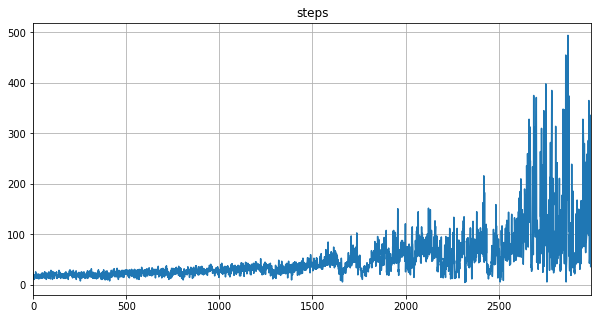

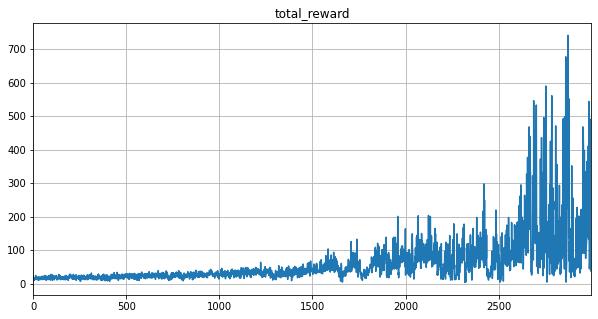

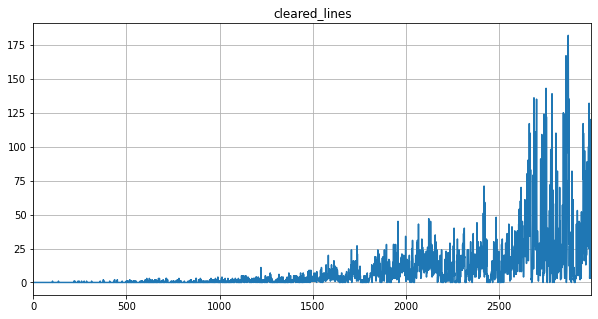

In [ ]:
import os
import logging

import numpy as np
import torch
!pip install torchinfo
from torchinfo import summary

# from src.agent import Agent
# from src.tetris import Tetris
# from src.plot import plot_result


def get_logger(
        dirname: str = 'log',
        filename: str = 'log.log',
        name: str = __name__
    ) -> logging.Logger:

    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    os.makedirs(dirname, exist_ok=True)
    logpath = os.path.join(dirname, filename)
    if os.path.exists(logpath):
        os.remove(logpath)

    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    handler = logging.FileHandler(logpath)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    return logger


experiment_name = "demo"

logdir = 'dir'
logfile = experiment_name + '.log'
weightdir = 'models'
weight_pretrained = ''
weightfile = experiment_name + '.pth'
plotdir = 'results'

num_episodes = 3000
max_steps = 500

height = 20
width = 10
block_size = 20

lr = 1e-4
batch_size = 512
gamma = 0.99
initial_eps = 1.0
final_eps = 0.001
num_decay_epochs = 2000
capacity = 30000
device = "cuda:0" if torch.cuda.is_available() else "cpu"

env = Tetris(num_rows=height, num_cols=width, block_size=block_size)
agent = Agent(
    lr=lr,
    batch_size=batch_size,
    gamma=gamma,
    initial_eps=initial_eps,
    final_eps=final_eps,
    num_decay_epochs=num_decay_epochs,
    capacity=capacity,
    device=device)
logger = get_logger(filename=logfile)

logger.info('-'*40 + ' Parameters ' + '-'*40)
logger.info(f'''
    # of episodes: {num_episodes}
    max steps: {max_steps}
    learning rate: {lr}
    batch size: {batch_size}
    gamma: {gamma}
    initial epsilon: {initial_eps}
    final epsilon: {final_eps}
    num_decay_epochs: {num_decay_epochs}
    memory capacity: {capacity}
    device: {device}
    model: '''
    )
logger.info(str(summary(agent.brain.model, (1, 1, 22, 10), verbose=0)) + '\n')

logger.info('-'*40 + ' Training log ' + '-'*40 + '\n')
history = {"steps": [], "total_reward": [], "cleared_lines": []}
max_step = 0
for episode in range(num_episodes):
    state = env.reset()[np.newaxis, ...].astype(np.float32)
    state = torch.from_numpy(state)

    total_reward = 0
    for step in range(max_steps):
        next_steps = env.get_next_states()
        next_actions, next_states = zip(*next_steps.items())
        next_states = np.stack(next_states)[:, np.newaxis].astype(np.float32)
        next_states = torch.from_numpy(next_states).to(device)

        next_state, action = agent.get_action(
            next_states, next_actions, episode)

        reward, done = env.step(action)
        total_reward += reward

        reward = torch.FloatTensor([reward]).to(device)
        action = torch.tensor([action], device=device)
        agent.memorize(state.to(device), action,
                       next_state.to(device), reward, done)
        agent.update_qval()

        state = next_state

        if done:
            message = f"Episode: {episode:4d}/{num_episodes:04d}\t" + \
                f"Step: {step:4d}/{max_steps:3d}\t" + \
                f"Cleared lines: {env.cleared_lines:3d}\t" + \
                f"Total Reward: {total_reward}"
            logger.info(message)
            history["steps"].append(step)
            history["total_reward"].append(total_reward)
            history["cleared_lines"].append(env.cleared_lines)

            if step > max_step - 25:
                os.makedirs(weightdir, exist_ok=True)
                max_step = step
                agent.save_model(os.path.join(weightdir, weightfile))
                logger.info("Model saved.")
            break
            break

plot_result(history, dirname=plotdir, prefix=experiment_name)
# agent.save_model(os.path.join(weightdir, weight_save))

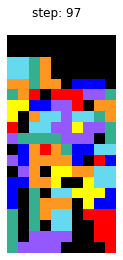

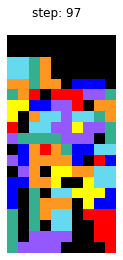

In [ ]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import torch

# from src.tetris import Tetris
# from src.agent import Agent


experiment_name = "demo"

device = "cuda:0"
weightdir = "models"
weight_pretrained = experiment_name + ".pth"

env = Tetris()
env.reset()
# agent = Agent(device=device)
agent.load_model(os.path.join(weightdir, weight_pretrained))

fig = plt.figure()
img = plt.imshow(env.render())
fig.suptitle('step: 0')
step = 0
while True:
    next_steps = env.get_next_states()
    next_actions, next_states = zip(*next_steps.items())
    next_states = np.stack(next_states)[:, np.newaxis].astype(np.float32)
    next_states = torch.from_numpy(next_states).to(device)
    action = agent.get_action_eval(next_states.to(device), next_actions)
    reward, done = env.step(action)

    display.clear_output(wait=True)

    img.set_data(env.render())
    fig.suptitle('step: {}'.format(step + 1))
    step = step + 1
    plt.axis('off')
    display.display(plt.gcf())
    # plt.pause(0.50)
    time.sleep(0.5)

    if done:
        break
plt.show()